## **Data Preprocessing Based on EDA Insights**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. I'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, I will:


In [59]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [60]:
# Loading the cleaned data from EDA
data_process = pd.read_csv("EDA_clean_data.csv")

In [61]:
data_process.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [62]:
# Let's make the `Loan_ID` the index
data_process.set_index("Loan_ID", inplace=True)

In [63]:
# Let's view of dataset again
data_process.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0.0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y
LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [64]:
# Let make a copy for preprocess
df = data_process.copy()

# check for missing values, it should be zero according to EDA report
print("")
print("--------------------------------")
print("Checking Missing Values")
print("--------------------------------")
missing_vals= df.isnull().sum()
if missing_vals.sum()>0:
    print(missing_vals[missing_vals>0])
else:
    print("No missing values as expected from EDA")

# check for duplicates
print("")
print("--------------------------------")
print("Checking duplicates rows")
print("--------------------------------")
duplicates=df.duplicated().sum()
if duplicates>0:
    print(f"The number of duplicate rows: {duplicates}")
    print(f"Percentage of duplicates:{duplicates/len(df)*100:.2f}%")

else:
    print(f"No duplicate rows")

# check skewness for the claimed variables in EDA report as right skewed
print("")
print("--------------------------------")
print("Checking skewness of Features")
print("--------------------------------")

claimed_features=['ApplicantIncome','CoapplicantIncome','LoanAmount']
for col in claimed_features:
    skew_val= df[col].skew()
    print(f"{col} Skewness is: {skew_val:.2f}, ({"right-skewed" if skew_val > 0.5 else "approximately normal"})")
    
# check correlation with target
# print("")
# print("--------------------------------")
# print("Checking correlation of Features")
# print("--------------------------------")

# correlations = df.select_dtypes(include=['number']).corr()['Loan_Status'].sort_values(key=abs, ascending=False)
# # Creating the high signal features
# high_signal = correlations[abs(correlations) > 0.2].drop('Loan_Status')
# # Creating the low signal features
# low_signal = correlations[abs(correlations) < 0.1]

# print("High-signal features (|correlation| > 0.2):")
# for feature, corr in high_signal.items():
#     print(f"    {feature}: {corr:.3f}")

# print("\nLow-signal features (|correlation| < 0.1):")
# for feature, corr in low_signal.items():
#     print(f"    {feature}: {corr:.3f}")


--------------------------------
Checking Missing Values
--------------------------------
No missing values as expected from EDA

--------------------------------
Checking duplicates rows
--------------------------------
No duplicate rows

--------------------------------
Checking skewness of Features
--------------------------------
ApplicantIncome Skewness is: 6.54, (right-skewed)
CoapplicantIncome Skewness is: 7.49, (right-skewed)
LoanAmount Skewness is: 2.74, (right-skewed)


### **Outlier Treatment**

IQR-capping for extreme ApplicantIncome, Coapplication Income and Loan Amount 

In [65]:
# Let's define function to do IQR clipping
def IQR_Clipping(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # get the number of capped outliers
    outliers_count = ((df[column] < lower) | (df[column] > upper)).sum()
    if outliers_count > 0:
        df[column] = np.where(df[column]<lower, lower, np.where(df[column]>upper, upper, df[column]))
    print(f"\nTotal outliers capped for {column}: {outliers_count}")
    

In [66]:
for col in ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]:
    IQR_Clipping(col)


Total outliers capped for ApplicantIncome: 50

Total outliers capped for CoapplicantIncome: 18

Total outliers capped for LoanAmount: 41


### **Handle Skewed Variables**

In [67]:
# As suggested from EDA, we are using log transform because it is right skewed
# Log-transform skewed variables(e.g., ApplicantIncome CoapplicantIncome and LoanAmount)
df["ApplicantIncome"] = np.log1p(df["ApplicantIncome"])
df["CoapplicantIncome"] = np.log1p(df["CoapplicantIncome"])
df["LoanAmount"] = np.log1p(df["LoanAmount"])

### **Feature Engineering** - Create an interaction features

- Total Income (TotalIncome = ApplicantIncome + CoapplicantIncome)
- Debt-to-Income Ratio (DTI = LoanAmount / TotalIncome)
- Equated Monthly Instalment Feature (EMI = LoanAmount / Loan_Amount_Term)

In [68]:
# Total Income
df["TotalIncome"] = df["ApplicantIncome"] + df["CoapplicantIncome"]

# Debt to income ratio (DTI)
df["DTI"] = df["LoanAmount"] / df["TotalIncome"]

# Equated Monthly Instalment (EMI)
df["EMI"] = df["LoanAmount"] / df["Loan_Amount_Term"]

engineered_features = ["TotalIncome", "DTI", "EMI"]

In [69]:
# Let get our numerical column before label encoding
num_cols = df.select_dtypes(include='number').columns
num_cols

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'DTI', 'EMI'],
      dtype='object')

### **Encoded categorical variables**

In [70]:
# Let encode our categorical feature into numerical.
categorical_col = df.select_dtypes(include='object').columns
categorical_col

Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area',
       'Loan_Status'],
      dtype='object')

I will be doing `label encoding` for binary column and `One-hot encoding` for multi-category column.

In [72]:
# Label encoding
label_encode = LabelEncoder()

binary_col = ["Gender", "Married", "Education", "Self_Employed", "Loan_Status"]

for col in binary_col:
    df[col] = label_encode.fit_transform(df[col])
    
# One-hot encoding
df = pd.get_dummies(df, columns=["Property_Area"], drop_first=True)

# Let's have the snapshot
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,DTI,EMI,Property_Area_Semiurban,Property_Area_Urban
Loan_ID,,,,,,,,,,,,,,,,
LP001002,1,0,0.0,0,0,8.674197,0.000000,4.859812,360.0,1.0,1,8.674197,0.560261,0.013499,False,True
LP001003,1,1,1.0,0,0,8.430327,7.319202,4.859812,360.0,1.0,0,15.749530,0.308569,0.013499,False,False
LP001005,1,1,0.0,0,1,8.006701,0.000000,4.204693,360.0,1.0,1,8.006701,0.525147,0.011680,False,True
LP001006,1,1,0.0,1,0,7.857094,7.765993,4.795791,360.0,1.0,1,15.623087,0.306968,0.013322,False,True
LP001008,1,0,0.0,0,0,8.699681,0.000000,4.955827,360.0,1.0,1,8.699681,0.569656,0.013766,False,True


### **Scaled numeric data**

In [73]:
num_cols

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'DTI', 'EMI'],
      dtype='object')

In [74]:
# Let normalize numeric values to help algorithms like Logistic Regression or SVM perform better.
scaler = StandardScaler()
df[num_cols]= scaler.fit_transform(df[num_cols])
df[num_cols].std()

Dependents           1.000815
ApplicantIncome      1.000815
CoapplicantIncome    1.000815
LoanAmount           1.000815
Loan_Amount_Term     1.000815
Credit_History       1.000815
TotalIncome          1.000815
DTI                  1.000815
EMI                  1.000815
dtype: float64

In [75]:
# Let's see snapshot
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,DTI,EMI,Property_Area_Semiurban,Property_Area_Urban
Loan_ID,,,,,,,,,,,,,,,,
LP001002,1,0,-0.737806,0,0,0.689316,-1.109654,0.039060,0.273231,0.411733,1,-1.058732,1.082314,-0.141648,False,True
LP001003,1,1,0.253470,0,0,0.241735,0.791149,0.039060,0.273231,0.411733,0,0.863370,-0.872878,-0.141648,False,False
LP001005,1,1,-0.737806,0,1,-0.535757,-1.109654,-1.449687,0.273231,0.411733,1,-1.240066,0.809542,-0.243742,False,True
LP001006,1,1,-0.737806,1,0,-0.810334,0.907181,-0.106428,0.273231,0.411733,1,0.829020,-0.885311,-0.151625,False,True
LP001008,1,0,-0.737806,0,0,0.736088,-1.109654,0.257252,0.273231,0.411733,1,-1.051809,1.155299,-0.126685,False,True


**Feature Selection**

In [76]:
# Let see the correlation again with encoded categorical label included
corr = df.corr()['Loan_Status'].abs().sort_values(ascending=False)
print(corr)

Loan_Status                1.000000
Credit_History             0.540556
Property_Area_Semiurban    0.136540
Married                    0.091478
DTI                        0.087104
Education                  0.085884
TotalIncome                0.069065
CoapplicantIncome          0.064302
Property_Area_Urban        0.043621
LoanAmount                 0.039733
Loan_Amount_Term           0.022549
Gender                     0.017987
ApplicantIncome            0.012166
Dependents                 0.010118
Self_Employed              0.003700
EMI                        0.001630
Name: Loan_Status, dtype: float64


In [77]:
# As evidence from EDA, Credit_History is the only feature that gives a moderate or useful signal for predicting loan status.

# Using the whole dataset, let select feature with correlation of >0.05 with the target.
selected_features = corr[corr>0.05].index.tolist()
selected_features.remove('Loan_Status')
no_selected_feature = len(selected_features)
print("Total no of features(Encoding & Engineered):", len(df.columns))
print("No of features selected:", no_selected_feature)
print("No of features to discard (low correlations):", len(df.columns) - no_selected_feature)
print("Selected features are:", selected_features)
df[selected_features].head(2)

Total no of features(Encoding & Engineered): 16
No of features selected: 7
No of features to discard (low correlations): 9
Selected features are: ['Credit_History', 'Property_Area_Semiurban', 'Married', 'DTI', 'Education', 'TotalIncome', 'CoapplicantIncome']


,Credit_History,Property_Area_Semiurban,Married,DTI,Education,TotalIncome,CoapplicantIncome
Loan_ID,,,,,,,
LP001002,0.411733,False,0,1.082314,0,-1.058732,-1.109654
LP001003,0.411733,False,1,-0.872878,0,0.863370,0.791149


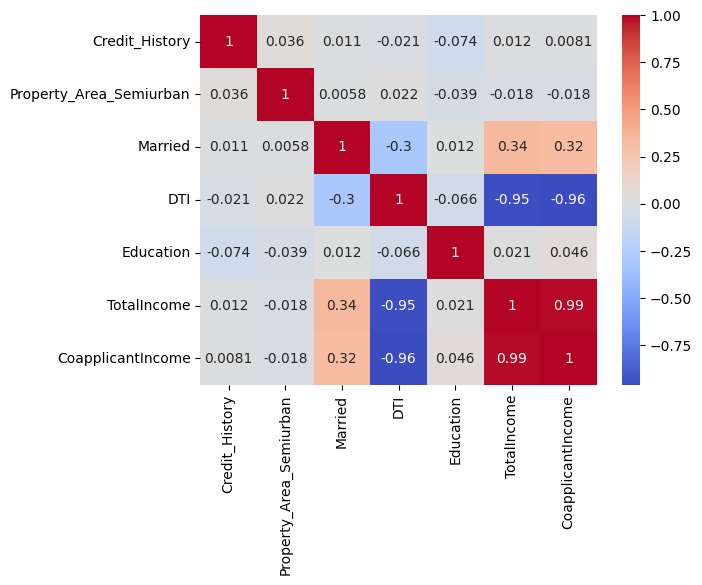

In [78]:
# for multicollinearity check
sns.heatmap(df[selected_features].corr(), annot=True, cmap="coolwarm")
plt.show()